# Library

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import scale 

# Read the dataset

In [35]:
df = pd.read_csv('/Users/minyan/Documents/stats780/Project_DS/csgo_round_snapshots.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     122410 non-null  float64
 1   ct_score                      122410 non-null  float64
 2   t_score                       122410 non-null  float64
 3   map                           122410 non-null  object 
 4   bomb_planted                  122410 non-null  bool   
 5   ct_health                     122410 non-null  float64
 6   t_health                      122410 non-null  float64
 7   ct_armor                      122410 non-null  float64
 8   t_armor                       122410 non-null  float64
 9   ct_money                      122410 non-null  float64
 10  t_money                       122410 non-null  float64
 11  ct_helmets                    122410 non-null  float64
 12  t_helmets                     122410 non-nul

In [36]:
df.isnull().sum()

time_left                    0
ct_score                     0
t_score                      0
map                          0
bomb_planted                 0
                            ..
ct_grenade_molotovgrenade    0
t_grenade_molotovgrenade     0
ct_grenade_decoygrenade      0
t_grenade_decoygrenade       0
round_winner                 0
Length: 97, dtype: int64

In [37]:
df['round_winner'] = df['round_winner'].apply(lambda x: 1 if x == 'CT' else 0)
print(df['round_winner'].value_counts())

round_winner
0    62406
1    60004
Name: count, dtype: int64


/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='round_winner', ylabel='count'>

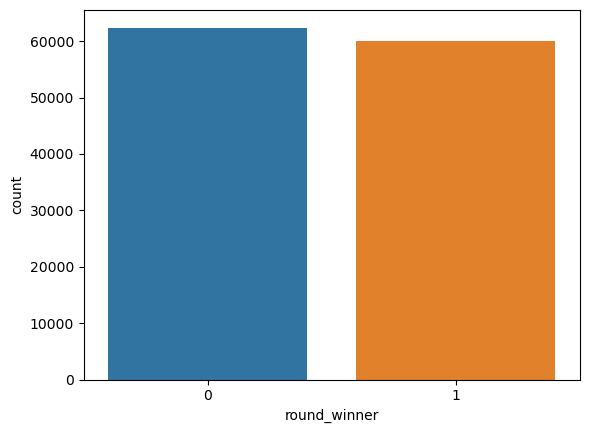

In [38]:
sns.countplot(x='round_winner', data=df)

# Data preprocessing

In [39]:
df['bomb_planted'] = df['bomb_planted'].astype(int)
n = 10
df_selected = df.iloc[:, list(range(n)) + [-1]]
df_selected = df_selected.drop('map', axis=1)

## Scaling

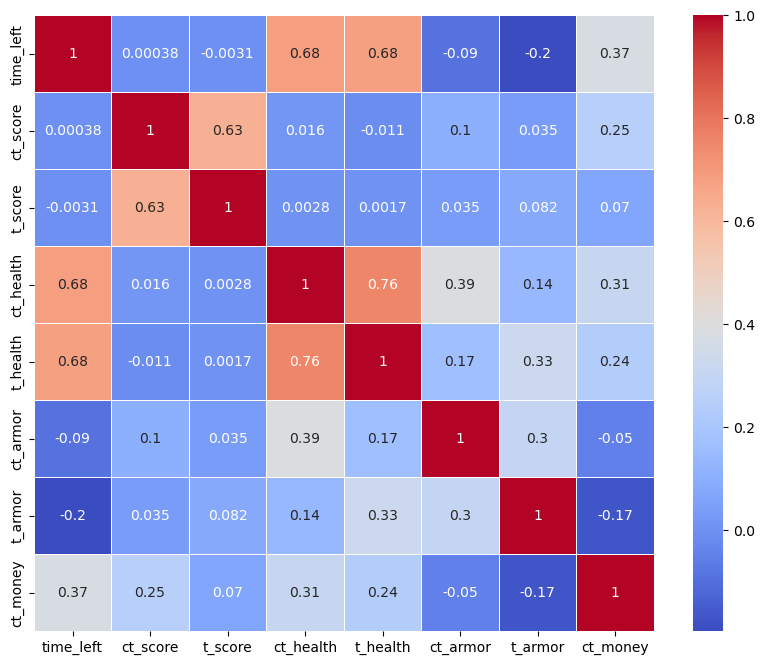

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   time_left     122410 non-null  float64
 1   ct_score      122410 non-null  float64
 2   t_score       122410 non-null  float64
 3   ct_health     122410 non-null  float64
 4   t_health      122410 non-null  float64
 5   ct_armor      122410 non-null  float64
 6   t_armor       122410 non-null  float64
 7   ct_money      122410 non-null  float64
 8   bomb_planted  122410 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 8.4 MB


/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse i

In [40]:
n = 10
df_selected = df.iloc[:, list(range(n)) + [-1]]
df_selected = df_selected.drop('map', axis=1)

X = df_selected.drop(['round_winner', 'bomb_planted'], axis=1)
Y = df_selected['round_winner']

correlation_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.savefig('corr.png')
plt.show()

from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X)
X = pd.DataFrame(std.transform(X), columns=X.columns)
X['bomb_planted'] = df_selected['bomb_planted']
X.info()
#X_pca = pd.DataFrame(scale(df_selected), index=df_selected.index, columns=df_selected.columns)

## Spliting

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=8964)

## PCA

In [42]:
from sklearn.decomposition import PCA

pca_X = PCA()

X_pca = pd.DataFrame(pca_X.fit_transform(X), columns=X.columns, index=X.index)
X_pca

#Train/test for decision trees
X_train_p, X_test_p, Y_train_p, Y_test_p = train_test_split(X_pca, Y, test_size=0.3, random_state=8964)

/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


# Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(max_depth=16, min_samples_split=80, random_state=8964)
tree.fit(X_train_p,Y_train_p)

# predictions=tree.predict(X_train)
# print(accuracy_score(Y_train,predictions)) # clearly overfitting

predictions=tree.predict(X_test_p)
tree_score=accuracy_score(Y_test_p,predictions)
tree_score

/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse i

0.7345805081284209

# Random Forest

In [54]:
rf = RandomForestClassifier(n_estimators=100, random_state=8964, max_depth=10)  # For classification
rf.fit(X_train_p, Y_train_p)
Y_pred = rf.predict(X_test_p)

# For classification
accuracy = accuracy_score(Y_test_p, Y_pred)
accuracy

# from sklearn.model_selection import GridSearchCV
# rf = RandomForestClassifier(random_state=8964)
# param_grid = {
#     'min_samples_split': [2, 4, 6, 8, 10]  # You can choose a range of values to test
# }
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train_p, Y_train_p)
# print(f"Best Parameter: {grid_search.best_params_}")
# print(f"Best Score: {grid_search.best_score_}")


/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse i

0.753097513819677

### Overfitting?

In [55]:
Y_pred_1 = rf.predict(X_train_p)
accuracy = accuracy_score(Y_train_p, Y_pred_1)
accuracy

/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/minyan/anaconda3/envs/stats780f23/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse i

0.7807835494299018

### Feature Importance

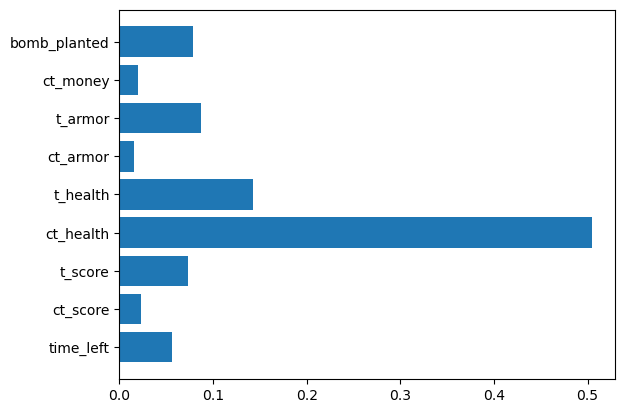

In [57]:
plt.barh(X_train.columns,rf.feature_importances_)
plt.savefig('feature.png')

## Keras

In [45]:
from tensorflow import keras

# Set model parameters
n_layers = 4
n_nodes = 300
regularized = False
dropout = True
epochs = 50

# Make a Keras DNN model
model = keras.models.Sequential()
model.add(keras.layers.BatchNormalization())
for n in range(n_layers):
    if regularized:
        model.add(keras.layers.Dense(n_nodes, kernel_initializer="he_normal",
         kernel_regularizer=keras.regularizers.l1(0.01), use_bias=False))
    else:
        model.add(keras.layers.Dense(n_nodes,
         kernel_initializer="he_normal", use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
    if dropout:
        model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])

# Make a callback that reduces LR on plateau
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                 patience=5, min_lr=0.001)

# Make a callback for early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)

# Train DNN.
history = model.fit(np.array(X_train), np.array(Y_train), epochs=epochs,
     validation_data=(np.array(X_test), np.array(Y_test)),
      callbacks=[reduce_lr_cb, early_stopping_cb], batch_size=128)

Epoch 1/50
670/670 [==============================] - 6s 7ms/step - loss: 0.5067 - accuracy: 0.7244 - val_loss: 0.4796 - val_accuracy: 0.7359 - lr: 0.0010
Epoch 2/50
670/670 [==============================] - 4s 6ms/step - loss: 0.4842 - accuracy: 0.7317 - val_loss: 0.4704 - val_accuracy: 0.7403 - lr: 0.0010
Epoch 3/50
670/670 [==============================] - 4s 6ms/step - loss: 0.4802 - accuracy: 0.7354 - val_loss: 0.4679 - val_accuracy: 0.7393 - lr: 0.0010
Epoch 4/50
670/670 [==============================] - 4s 6ms/step - loss: 0.4766 - accuracy: 0.7368 - val_loss: 0.4665 - val_accuracy: 0.7429 - lr: 0.0010
Epoch 5/50
670/670 [==============================] - 5s 7ms/step - loss: 0.4760 - accuracy: 0.7374 - val_loss: 0.4662 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 6/50
670/670 [==============================] - 5s 7ms/step - loss: 0.4741 - accuracy: 0.7375 - val_loss: 0.4640 - val_accuracy: 0.7435 - lr: 0.0010
Epoch 7/50
670/670 [==============================] - 4s 7ms/step - lo

In [46]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_31 (Bat  (None, 9)                36        
 chNormalization)                                                
                                                                 
 dense_31 (Dense)            (None, 300)               2700      
                                                                 
 batch_normalization_32 (Bat  (None, 300)              1200      
 chNormalization)                                                
                                                                 
 activation_25 (Activation)  (None, 300)               0         
                                                                 
 dropout_25 (Dropout)        (None, 300)               0         
                                                                 
 dense_32 (Dense)            (None, 300)              

In [47]:
model.evaluate(X_test, Y_test)

1148/1148 [==============================] - 1s 778us/step - loss: 0.4570 - accuracy: 0.7431


[0.45697471499443054, 0.7430765628814697]